In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving kaggle.json to kaggle.json


In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download balraj98/deepglobe-land-cover-classification-dataset


Dataset URL: https://www.kaggle.com/datasets/balraj98/deepglobe-land-cover-classification-dataset
License(s): other
100% 2.74G/2.74G [00:41<00:00, 173MB/s]
100% 2.74G/2.74G [00:41<00:00, 71.5MB/s]


In [ ]:
!unzip 'deepglobe-land-cover-classification-dataset.zip' -d '/content/deepglobe_dataset'


Archive:  deepglobe-land-cover-classification-dataset.zip
  inflating: /content/deepglobe_dataset/class_dict.csv  
  inflating: /content/deepglobe_dataset/metadata.csv  
  inflating: /content/deepglobe_dataset/test/100877_sat.jpg  
  inflating: /content/deepglobe_dataset/test/103215_sat.jpg  
  inflating: /content/deepglobe_dataset/test/103742_sat.jpg  
  inflating: /content/deepglobe_dataset/test/110224_sat.jpg  
  inflating: /content/deepglobe_dataset/test/112946_sat.jpg  
  inflating: /content/deepglobe_dataset/test/114542_sat.jpg  
  inflating: /content/deepglobe_dataset/test/115800_sat.jpg  
  inflating: /content/deepglobe_dataset/test/118757_sat.jpg  
  inflating: /content/deepglobe_dataset/test/119896_sat.jpg  
  inflating: /content/deepglobe_dataset/test/120939_sat.jpg  
  inflating: /content/deepglobe_dataset/test/121151_sat.jpg  
  inflating: /content/deepglobe_dataset/test/123976_sat.jpg  
  inflating: /content/deepglobe_dataset/test/125014_sat.jpg  
  inflating: /content/de

In [ ]:
import os
os.listdir('/content/deepglobe_dataset')


['train', 'valid', 'test', 'metadata.csv', 'class_dict.csv']

In [ ]:
import pandas as pd
metadata_df = pd.read_csv('/content/deepglobe_dataset/metadata.csv')


In [ ]:
import os, cv2
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as album

In [ ]:
# !pip install torch torchvision --upgrade --user

In [ ]:
!pip install segmentation-models-pytorch==0.2.0
# !pip install torch torchvision --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.6/87.6 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.0/377.0 kB 11.3 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12403 sha256=0dfed27f4d660236587e9e6f981e300351fd1d1aeaa9a86ff9a22301952ad8d2
  Stored in directory: /root/.cache/pip/wheels/61/3a/b0/0b4c443c380bd934701b0a25e4aed76479e4fcaf1a6f955664
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=56e7345b4f555471845fdd8385f02a9a485c450180163f10ec03558350f8880b
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels
  Attempting uninstall: timm
    Found existing installation

In [ ]:
# !pip install -q -U segmentation-models-pytorch albumentations > /dev/null
# !pip install segmentation-models-pytorch
import segmentation_models_pytorch as smp

In [ ]:
DATA_DIR = '/content/deepglobe_dataset' # DATA_DIR est le chemin vers le dossier qui contient les données nécessaires pour l'entraînement et la validation du modèle.

metadata_df = pd.read_csv(os.path.join(DATA_DIR, 'metadata.csv'))#Le fichier metadata.csv contient des informations sur les images et leurs masques correspondants.
metadata_df = metadata_df[metadata_df['split']=='train']#Filtrage des images de type "train"
metadata_df = metadata_df[['image_id', 'sat_image_path', 'mask_path']]#Sélection des colonnes pertinentes
metadata_df['sat_image_path'] = metadata_df['sat_image_path'].apply(lambda img_pth: os.path.join(DATA_DIR, img_pth))
metadata_df['mask_path'] = metadata_df['mask_path'].apply(lambda img_pth: os.path.join(DATA_DIR, img_pth))
# Shuffle DataFrame
metadata_df = metadata_df.sample(frac=1).reset_index(drop=True)

# Perform 90/10 split for train / val
valid_df = metadata_df.sample(frac=0.1, random_state=42)
train_df = metadata_df.drop(valid_df.index)
len(train_df), len(valid_df)

(723, 80)

In [ ]:
class_dict = pd.read_csv(os.path.join(DATA_DIR, 'class_dict.csv'))
# Get class names
class_names = class_dict['name'].tolist()
# Get class RGB values
class_rgb_values = class_dict[['r','g','b']].values.tolist()

print('All dataset classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

All dataset classes and their corresponding RGB values in labels:
Class Names:  ['urban_land', 'agriculture_land', 'rangeland', 'forest_land', 'water', 'barren_land', 'unknown']
Class RGB values:  [[0, 255, 255], [255, 255, 0], [255, 0, 255], [0, 255, 0], [0, 0, 255], [255, 255, 255], [0, 0, 0]]


In [ ]:
# Useful to shortlist specific classes in datasets with large number of classes
select_classes = ['urban_land', 'agriculture_land', 'rangeland', 'forest_land', 'water', 'barren_land', 'unknown']

# Get RGB values of required classes
select_class_indices = [class_names.index(cls.lower()) for cls in select_classes]
select_class_rgb_values =  np.array(class_rgb_values)[select_class_indices]
print('Selected classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

Selected classes and their corresponding RGB values in labels:
Class Names:  ['urban_land', 'agriculture_land', 'rangeland', 'forest_land', 'water', 'barren_land', 'unknown']
Class RGB values:  [[0, 255, 255], [255, 255, 0], [255, 0, 255], [0, 255, 0], [0, 0, 255], [255, 255, 255], [0, 0, 0]]


In [ ]:
# helper function for data visualization
import numpy as np
import matplotlib.pyplot as plt
def visualize(**images):
    """
    Plot images in one row
    """
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]);
        plt.yticks([])
        # get title from the parameter names

    plt.title(name.replace('_',' ').title(), fontsize=20)
    plt.imshow(image)
    plt.show()


In [ ]:
import numpy as np

def one_hot_encode(label, label_values):
    """
    Convert a segmentation image label array to one-hot format
    by replacing each pixel value with a vector of length num_classes.

    # Arguments
        label: The 2D array segmentation image label
        label_values: List of unique label values to encode

    # Returns
        A 3D array with the same width and height as the input, but
        with a depth size of num_classes (length of label_values).
    """

    # Initialisation d'une liste vide pour stocker les cartes de classe
    semantic_map = []

    # Boucle pour chaque valeur de classe dans label_values
    for colour in label_values:
        # Créer une carte binaire pour chaque classe
        equality = np.equal(label, colour)  # Vérifie où les pixels sont égaux à 'colour'
        class_map = np.all(equality, axis=-1)  # Crée une carte de classe (1 ou 0)
        semantic_map.append(class_map)  # Ajouter la carte de classe à la liste

    # Empiler toutes les cartes de classes le long de l'axe de la profondeur
    semantic_map = np.stack(semantic_map, axis=-1)

    # Retourner la carte de classes en one-hot
    return semantic_map



In [ ]:
# Perform reverse one-hot-encoding on labels / preds
def reverse_one_hot(image):
    """
    Transform a 2D array in one-hot format (depth is num_classes),
    to a 2D array with only 1 channel, where each pixel value is
    the classified class key.
    # Arguments
        image: The one-hot format image

    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of 1, where each pixel value is the classified
        class key.
    """
    x = np.argmax(image, axis = -1)
    return x


In [ ]:
# Perform colour coding on the reverse-one-hot outputs
def colour_code_segmentation(image, label_values):
    """
    Given a 1-channel array of class keys, colour code the segmentation results.
    # Arguments
        image: single channel array where each value represents the class key.
        label_values

    # Returns
        Colour coded image for segmentation visualization"""
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]

    return x

In [ ]:
import cv2
import torch
from torch.utils.data import Dataset

class LandCoverDataset(Dataset):
    """DeepGlobe Land Cover Classification Challenge Dataset. Read images, apply augmentation and preprocessing transformations.

    Args:
        df (str): DataFrame containing images / labels paths
        class_rgb_values (list): RGB values of select classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transformation pipeline (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing (e.g. normalization, shape manipulation, etc.)
    """

    def __init__(self, df, class_rgb_values=None, augmentation=None, preprocessing=None):
        self.image_paths = df['sat_image_path'].tolist()
        self.mask_paths = df['mask_path'].tolist()

        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):
        """Load an image and its corresponding mask, apply augmentation and preprocessing."""
        # Read images and masks
        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB)

        # One-hot encode the mask
        mask = one_hot_encode(mask, self.class_rgb_values).astype('float')

        # Apply augmentations if provided
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # Apply preprocessing if provided
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

    def __len__(self):
        """Return the length of the dataset (number of images)."""
        return len(self.image_paths)


In [ ]:
"Visualize Sample Image and Mask 📈"

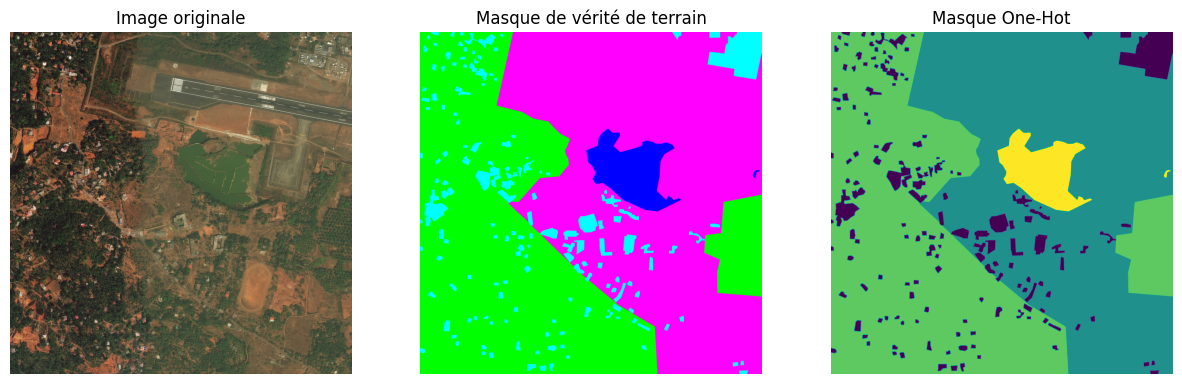

In [ ]:
dataset = LandCoverDataset(train_df, class_rgb_values=select_class_rgb_values)
random_idx = random.randint(0, len(dataset)-1)
image, mask = dataset[2]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

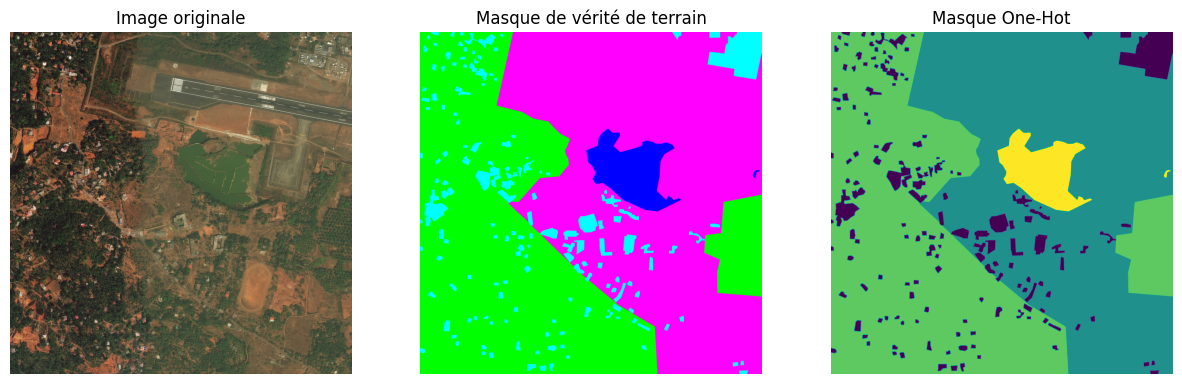

In [ ]:
dataset = LandCoverDataset(train_df, class_rgb_values=select_class_rgb_values)
random_idx = random.randint(0, len(dataset)-1)
image, mask = dataset[2]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

In [ ]:
"Defining Augmentations 🙃"

In [ ]:
def get_training_augmentation():
    train_transform = [
        album.RandomCrop(height=1024, width=1024, always_apply=True),
        album.HorizontalFlip(p=0.5),
        album.VerticalFlip(p=0.5),
    ]
    return album.Compose(train_transform)


def get_validation_augmentation():
    train_transform = [
        album.CenterCrop(height=1024, width=1024, always_apply=True),
    ]
    return album.Compose(train_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn=None):
    """Construct preprocessing transform
    Args:
        preprocessing_fn (callable): data normalization function
            (can be specific for each pretrained neural network)
            Return:
        transform: albumentations.Compose
    """
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))

    return album.Compose(_transform)

In [ ]:
"Visualize Augmented Images & Masks"

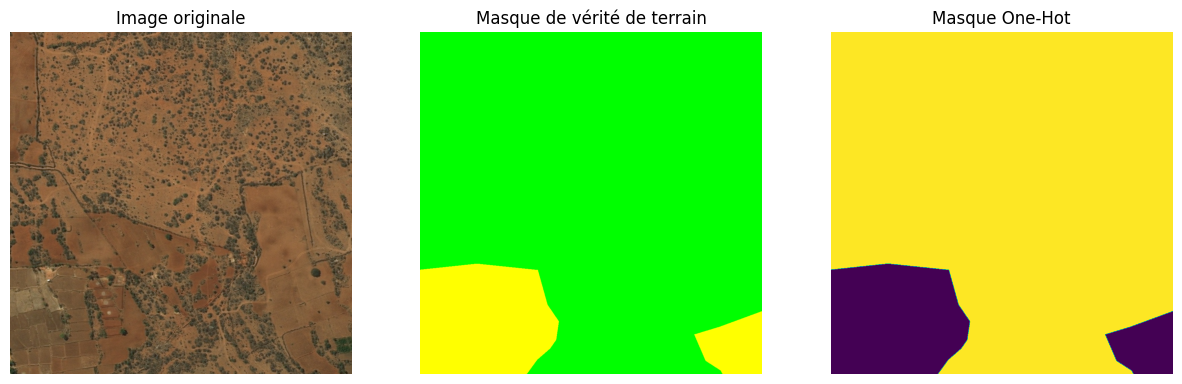

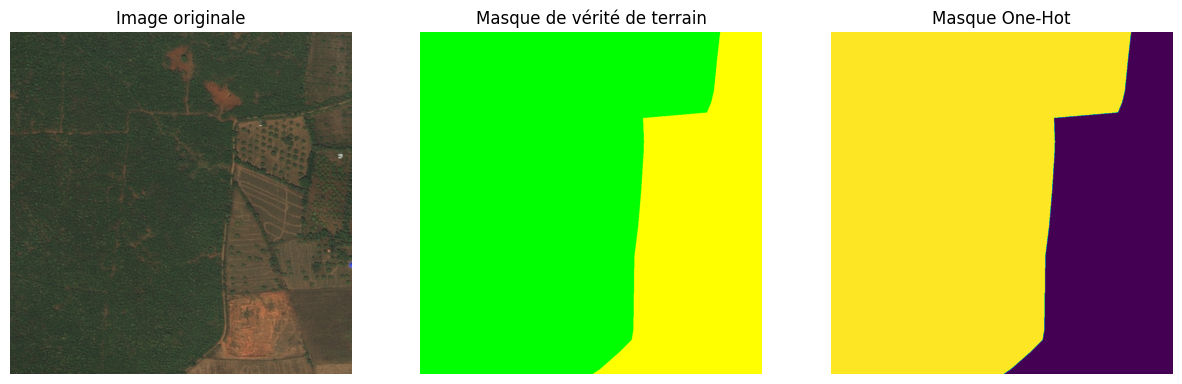

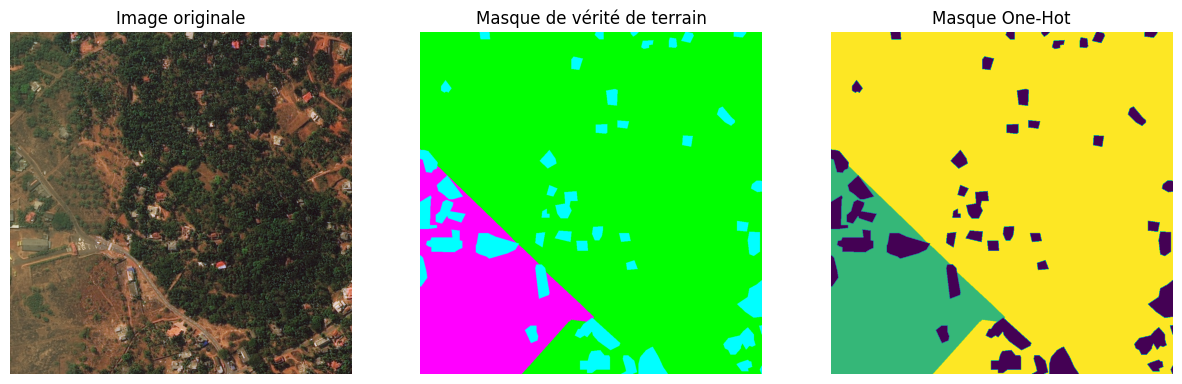

In [ ]:
augmented_dataset = LandCoverDataset(
    train_df,
    augmentation=get_training_augmentation(),
    class_rgb_values=select_class_rgb_values,
)

random_idx = random.randint(0, len(augmented_dataset)-1)

# Different augmentations on image/mask pairs
for idx in range(3):
    image, mask = augmented_dataset[idx]
    visualize(
        original_image = image,
        ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
        one_hot_encoded_mask = reverse_one_hot(mask)
    )

In [ ]:
"Training DeepLabV3+"
